In [1]:
import numpy as np
from collections import Counter
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import pandas as pd

import matplotlib.pyplot as plt


RANDOM_STATE = 0

2024-05-08 00:24:27.077169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 00:24:27.079252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 00:24:27.162239: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 00:24:27.530965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 00:24:28.580922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

### Data load, explore and preprocess
1. shape and size view
2. nan data check
3. class similarity

Train size: 18928
Test size: 4732
Image shape: (28, 28)

Nan value exists detect
X_train: False
y_train: False
X_test: False
y_test: False

num of class: Counter({6: 4201, 10: 2196, 0: 1741, 9: 1682, 5: 1651, 4: 1562, 8: 1546, 7: 1519, 3: 978, 1: 936, 2: 916})


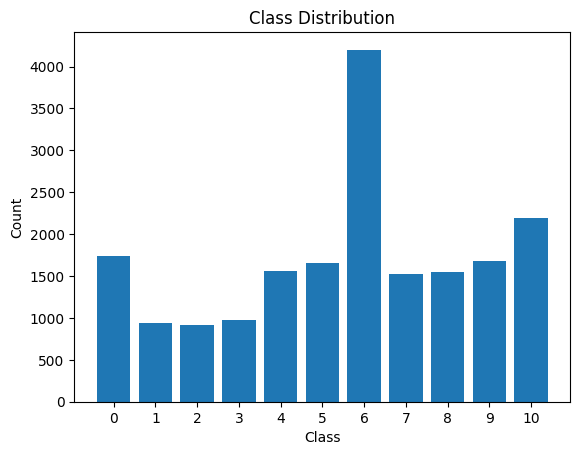

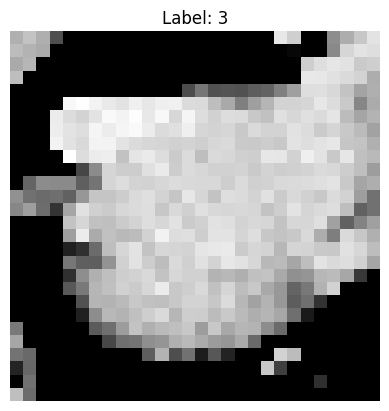

In [2]:
# loading
X_train = np.load('dataset/Assignment2Data/X_train.npy')
X_test = np.load('dataset/Assignment2Data/X_test.npy')
y_train = np.load('dataset/Assignment2Data/y_train.npy')
y_test = np.load('dataset/Assignment2Data/y_test.npy')

# data size and shape
print(f"Train size: {X_train.shape[0]}\nTest size: {X_test.shape[0]}\nImage shape: {X_test.shape[1:]}\n")

# Check nan values
def check_nan(data) -> bool:
    return np.isnan(data).any()

print(f"Nan value exists detect\nX_train: {check_nan(X_train)}\ny_train: {check_nan(y_train)}\nX_test: {check_nan(X_test)}\ny_test: {check_nan(y_test)}\n")

# num of class
cnt_class = Counter(y_train)
print(f"num of class: {cnt_class}")
classes = list(cnt_class.keys())
counts = list(cnt_class.values())

# visual of class
plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes)
plt.show()

# single image show
image_index = 3
image = X_train[image_index]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {y_train[image_index]}")
plt.axis('off')
plt.show()



In [7]:
'''
Preprocess
1. label one-hot encode (for FNN and CNN)
2. train-valid split and data reshape (for FNN and CNN)
'''

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
X_train_re = X_train.reshape(-1, 28, 28, 1)
X_val_re = X_val.reshape(-1, 28, 28, 1)
X_test_re = X_test.reshape(-1, 28, 28, 1)

y_train_encoded = to_categorical(y_train, 11)
y_val_encoded = to_categorical(y_val, 11)
y_test_encoded = to_categorical(y_test, 11)


/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/tmp/ipykernel_101956/2823694231.py:37: RuntimeWarning: divide by zero encountered in divide
  similarity_matrics[i][j] = 1 / distance


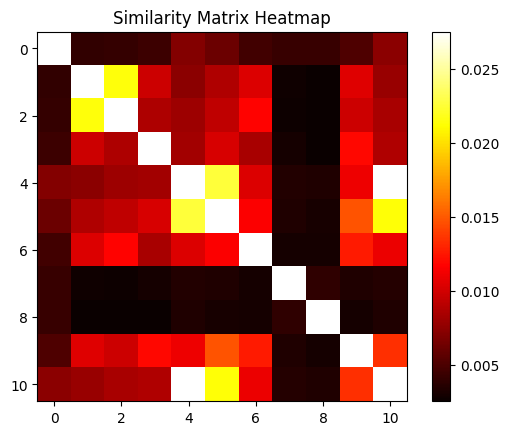

In [3]:
# Extract feature (for LinearSVC & similarity review)
# This cnn model is set just to extract feature for linearSVC and feature similarity review. it s not relevent to the MLP and CNN experiment.

input_shape = (28, 28, 1)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

all_features = model.predict(X_train)
all_features_test = model.predict(X_test)

# average feature for each class
feature_dict = {key:[] for key in cnt_class.keys()}
class_avg_feature = {key:None for key in cnt_class.keys()}

for idx, feature in enumerate(all_features):
    feature_dict[y_train[idx]].append(feature)

for key, features in feature_dict.items():
    class_avg_feature[key] = np.mean(features, axis=0)

# calculate similarity
similarity_matrics = np.zeros((11, 11))

sigma = 1.0 # similarity function param

for i in range(11):
    for j in range(11):
        distance = np.linalg.norm(class_avg_feature[i] - class_avg_feature[j])
        similarity_matrics[i][j] = 1 / distance

# hot map visual
plt.imshow(similarity_matrics, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix Heatmap')
plt.show()  


### Model build
1. Linear SVC
2. MLP
3. CNN

#### 1.Linear SVC  
model  
params search  
best model

In [5]:
# Linear SVC

SVC_clf = LinearSVC(dual="auto", random_state=RANDOM_STATE, tol=1e-3, C=1.0, verbose=True)

# training
SVC_clf.fit(all_features, y_train)

# Assessment
# accuracy, precision, recall, f1-score
y_pred = SVC_clf.predict(all_features_test)

acc_SVC = accuracy_score(y_test, y_pred)
pre_SVC = precision_score(y_test, y_pred, average='macro')
rec_SVC = recall_score(y_test, y_pred, average='macro')
f1_SVC = f1_score(y_test, y_pred, average='macro')

cm_SVC = confusion_matrix(y_test, y_pred)

print(f"Acc: {acc_SVC}\nPre: {pre_SVC}\nRec: {rec_SVC}\nF1: {f1_SVC}\n")
print(f"Confusion Matrix(SVC): {cm_SVC}")




[LibLinear]iter  1 act 1.301e+04 pre 1.298e+04 delta 1.151e-03 f 1.893e+04 |g| 2.260e+07 CG   1
cg reaches trust region boundary
iter  2 act 3.879e+02 pre 3.873e+02 delta 2.184e-03 f 5.918e+03 |g| 6.222e+05 CG   2
cg reaches trust region boundary
iter  3 act 4.485e+02 pre 4.485e+02 delta 4.528e-03 f 5.530e+03 |g| 3.292e+05 CG   2
cg reaches trust region boundary
iter  4 act 5.510e+02 pre 4.804e+02 delta 6.275e-03 f 5.082e+03 |g| 5.960e+05 CG   3
cg reaches trust region boundary
iter  5 act 4.251e+02 pre 3.797e+02 delta 9.988e-03 f 4.531e+03 |g| 5.780e+05 CG   3
cg reaches trust region boundary
iter  6 act 3.997e+02 pre 3.761e+02 delta 1.705e-02 f 4.106e+03 |g| 3.762e+05 CG   3
cg reaches trust region boundary
iter  7 act 3.944e+02 pre 3.424e+02 delta 2.287e-02 f 3.706e+03 |g| 2.419e+05 CG   4
iter  8 act 7.988e+01 pre 7.993e+01 delta 2.287e-02 f 3.311e+03 |g| 3.391e+05 CG   3
cg reaches trust region boundary
iter  9 act 3.207e+02 pre 2.959e+02 delta 3.760e-02 f 3.232e+03 |g| 1.233e+05 

In [16]:
'''
Params search
'''
# params grid
param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2'], 
    'loss': ['squared_hinge'], 
    'dual': ['auto'],
    'tol': [1e-3, 1e-4]
}

# grid search
linear_svc = LinearSVC(random_state=42)

grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='accuracy')

grid_search.fit(all_features, y_train)

# best params set
print("Best parameters found: ", grid_search.best_params_)

# best model
best_linear_svc = grid_search.best_estimator_
test_accuracy = best_linear_svc.score(all_features_test, y_test)
print("Test set accuracy: ", test_accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [18928, 15142]

In [ ]:
# Visual of LinearSVC params search
results = pd.DataFrame(grid_search.cv_results_)

param_names = grid_search.param_grid.keys()

fig, axes = plt.subplots(nrows=len(param_names), ncols=1, figsize=(10, 5 * len(param_names)))

for i, param_name in enumerate(param_names):
    param_values = results[param_name].unique()
    
    for value in param_values:
        subset = results[results[param_name] == value]
        axes[i].plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'{param_name}={value}')
    
    axes[i].set_title(f'Grid Search Results for {param_name}')
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Mean Test Score')
    axes[i].legend()

plt.tight_layout()

plt.show()

In [8]:
# Data Enhance (for both MLP and CNN)
train_datagen = ImageDataGenerator(
    rotation_range=20,        
    # width_shift_range=0.2,    
    # height_shift_range=0.2,
    # featurewise_std_normalization=True,        
    # zoom_range=0.2,                 
)

train_generator = train_datagen.flow(X_train_re, y_train_encoded, batch_size=4)

#### 2.MLP  
model  
params search  
best model

In [9]:
# Training setting (for MLP)
train_size = 15142
val_size = 3786
test_size = 4732
batch_size = 4
epochs = 8
lr = 0.01
train_steps = train_size // batch_size
valid_steps = test_size // batch_size

In [10]:
# MLP model build

def FCNN():
        '''for single model training'''
        FCNN_model = Sequential()
        FCNN_model.add(Flatten(input_shape=(28, 28, 1)))  

        FCNN_model.add(Dense(128, activation='relu'))
        FCNN_model.add(Dropout(0.5))

        FCNN_model.add(Dense(64, activation='relu'))
        FCNN_model.add(Dropout(0.5))

        FCNN_model.add(Dense(11, activation='sigmoid'))

        optimizer = Adam(learning_rate=lr)

        FCNN_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['categorical_accuracy'])
        return FCNN_model

def FCNN_tuning(hp):
        '''for params search'''
        model = Sequential()
        # flatten
        model.add(Flatten(input_shape=(28, 28, 1)))

        # 1th dense
        model.add(Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'))
        # drop out
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # 2th dense
        model.add(Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'))

        # 3th dense output
        model.add(Dense(11, activation='softmax'))

        # compile
        model.compile(
                optimizer=Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

        return model

In [11]:
# MLP train & test
# train
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max')]

FCNN_model = FCNN()

FCNN_model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=(X_val_re, y_val_encoded),
        validation_steps=valid_steps,
        callbacks=callbacks
        )

# test
test_loss, test_accuracy = FCNN_model.evaluate(X_test_re, y_test_encoded, verbose=2)
y_pred_MLP = FCNN_model.predict(X_test_re)
cm_MLP = confusion_matrix(y_test_encoded, y_pred_MLP)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\nConfusion Matrix:{cm_MLP}")

Epoch 1/8


/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  41/3785 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - categorical_accuracy: 0.0801 - loss: 1338.7130      

/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - categorical_accuracy: 0.2005 - loss: 77.6152 - val_categorical_accuracy: 0.2314 - val_loss: 2.2894
Epoch 2/8
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.2500 - loss: 2.2482

2024-05-08 00:31:13.531674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: categorical_accuracy,loss,val_categorical_accuracy,val_loss
  current = self.get_monitor_value(logs)
2024-05-08 00:31:13.552516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 

3785/3785 ━━━━━━━━━━━━━━━━━━━━ 1s 164us/step - categorical_accuracy: 0.2500 - loss: 2.2482 - val_categorical_accuracy: 0.2314 - val_loss: 2.2895
Epoch 3/8
  76/3785 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.2141 - loss: 2.3039

2024-05-08 00:31:14.168113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.2186 - loss: 2.3786 - val_categorical_accuracy: 0.2319 - val_loss: 2.2876
Epoch 4/8
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - categorical_accuracy: 0.2500 - loss: 2.0773

2024-05-08 00:31:22.365622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 00:31:22.377317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - categorical_accuracy: 0.2500 - loss: 2.0773 - val_categorical_accuracy: 0.2319 - val_loss: 2.2875
Epoch 5/8
  82/3785 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.1846 - loss: 2.3411   

2024-05-08 00:31:22.984218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.2151 - loss: 2.3871 - val_categorical_accuracy: 0.2324 - val_loss: 2.3548
Epoch 6/8
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - categorical_accuracy: 0.2500 - loss: 2.2858

2024-05-08 00:31:30.698651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 00:31:30.710799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 1s 160us/step - categorical_accuracy: 0.2500 - loss: 2.2858 - val_categorical_accuracy: 0.2324 - val_loss: 2.3547
Epoch 7/8
  89/3785 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - categorical_accuracy: 0.2120 - loss: 2.3354   

2024-05-08 00:31:31.309118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.2225 - loss: 2.3120 - val_categorical_accuracy: 0.2338 - val_loss: 2.3732
Epoch 8/8
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - categorical_accuracy: 0.2500 - loss: 2.2094

2024-05-08 00:31:39.354573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 00:31:39.367889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 1s 172us/step - categorical_accuracy: 0.2500 - loss: 2.2094 - val_categorical_accuracy: 0.2338 - val_loss: 2.3734
148/148 - 0s - 873us/step - categorical_accuracy: 0.2230 - loss: 2.3032
Test Loss: 2.3032195568084717, Test Accuracy: 0.22295013070106506


2024-05-08 00:31:40.011870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [12]:
# params tuning
FCNN_tuner = RandomSearch(
    FCNN_tuning,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='dir_FCNN',
    project_name='FCNN')

tensorboard_callback = TensorBoard(log_dir='./FCNN_logs')

FCNN_tuner.search(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded), callbacks=[tensorboard_callback])

best_hps = FCNN_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# model built on best params set
FCNN_tuning_model = FCNN_tuner.hypermodel.build(best_hps)

# train
history = FCNN_tuning_model.fit(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded))

# assessment
test_loss, test_acc = FCNN_tuning_model.evaluate(X_test_re, y_test_encoded)
print(f"Test accuracy: {test_acc}")

%tensorboard --logdir=./FCNN_logs

Trial 1 Complete [00h 01m 31s]

Best val_accuracy So Far: None
Total elapsed time: 00h 01m 31s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
448               |512               |units
0.4               |0.1               |dropout
0.0001            |0.001             |learning_rate

Epoch 1/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - categorical_accuracy: 0.3121 - loss: 51.7593 - val_categorical_accuracy: 0.4617 - val_loss: 2.8066
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - categorical_accuracy: 0.3999 - loss: 2.9106 - val_categorical_accuracy: 0.4645 - val_loss: 1.9845
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - categorical_accuracy: 0.4327 - loss: 2.0498 - val_categorical_accuracy: 0.4808 - val_loss: 1.7781
Epoch 4/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - categorical_accuracy: 0.4565 - loss: 1.8129 - val_categorical_accuracy: 0.5038 - val_loss: 1.5731
Epoch 5/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - categorical_accurac

KeyboardInterrupt: 

#### 3.CNN  
model  
params search  
best model

In [13]:
# Training setting
train_size = 15142
val_size = 3786
test_size = 4732
batch_size = 4
epochs = 12
lr = 0.001
train_steps = int(train_size / batch_size)
valid_steps = int(test_size / batch_size)

In [14]:
# CNN
def CNN():
    '''for single model training'''
    input_shape = (28, 28, 1)

    CNN_model = Sequential()

    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_model.add(Flatten())

    CNN_model.add(Dense(128, activation='relu'))

    CNN_model.add(Dropout(0.5))

    CNN_model.add(Dense(11, activation='softmax'))

    optimizer = Adam(learning_rate=lr)

    CNN_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return CNN_model

def CNN_tuning(hp):
    '''for params tuning'''
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=64, max_value=512, step=64),
        activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    # compile
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [ ]:
# CNN train & test
# train
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max')]

CNN_model = CNN()

CNN_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=(X_val_re, y_val_encoded),
    validation_steps=valid_steps,
    callbacks=callbacks
    )

# test
test_loss, test_accuracy = CNN_model.evaluate(X_test_re, y_test_encoded, verbose=2)
y_pred_CNN = CNN_model.predict(y_test_encoded)
cm_CNN = confusion_matrix(y_test_encoded, y_pred_CNN)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\nConfusion Matrix: {cm_CNN}")

In [15]:
# params search
CNN_tuner = RandomSearch(
    CNN_tuning,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='dir_CNN',
    project_name='CNN')

tensorboard_callback = TensorBoard(log_dir='./CNN_logs')

CNN_tuner.search(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded), callbacks=[tensorboard_callback])

best_hps = CNN_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# model built on best params set
CNN_tuning_model = CNN_tuner.hypermodel.build(best_hps)

# train
history = CNN_tuning_model.fit(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded))

# assessment
test_loss, test_acc = CNN_tuning_model.evaluate(X_test_re, y_test_encoded)
print(f"Test accuracy: {test_acc}")

%tensorboard --logdir=./CNN_logs

/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
3                 |3                 |kernel_size
192               |192               |units
0.001             |0.001             |learning_rate

Epoch 1/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4863 - loss: 4.0333 - val_accuracy: 0.7443 - val_loss: 0.8023
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7753 - loss: 0.6679 - val_accuracy: 0.7995 - val_loss: 0.6424
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8383 - loss: 0.4904 - val_accuracy: 0.8092 - val_loss: 0.6129
Epoch 4/10
128/474 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8655 - loss: 0.3965

KeyboardInterrupt: 